# Imports

In [86]:
import os

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import (accuracy_score, classification_report,
                             cohen_kappa_score, confusion_matrix, f1_score,
                             make_scorer, precision_score, recall_score)
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     StratifiedShuffleSplit, cross_val_predict,
                                     cross_val_score, cross_validate,
                                     train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (MinMaxScaler, PolynomialFeatures,
                                   StandardScaler, LabelEncoder)


#for quick printing of scores
def model_evaluation(y_true , y_pred):
    print('Accuracy:', accuracy_score(y_true, y_pred))
    print('Precision:', precision_score(y_true, y_pred, average="micro"))
    print('Recall:', recall_score(y_true, y_pred, average="micro"))
    print('F1 score:', f1_score(y_true, y_pred, average="micro"))
    print('Cohen\'s Kappa', cohen_kappa_score(y_true, y_pred))
    pass

kappa_score = make_scorer(cohen_kappa_score)

def model_evaluation_cv(estimator, X , y, cv=3):
    cv_acc = cross_val_score(estimator, X, y, cv=cv, scoring="accuracy")
    cv_prc = cross_val_score(estimator, X, y, cv=cv, scoring="precision_micro")
    cv_rec = cross_val_score(estimator, X, y, cv=cv, scoring="recall_micro")
    cv_f1 = cross_val_score(estimator, X, y, cv=cv, scoring="f1_micro")
    cv_kappa = cross_val_score(estimator, X, y, cv=cv, scoring=kappa_score)

    print('Mean Accuracy:', cv_acc.mean(), "Standard Deviation", cv_acc.std())
    print('Mean Precision:', cv_prc.mean(), "Standard Deviation", cv_prc.std())
    print('Mean Recall:', cv_rec.mean(), "Standard Deviation", cv_rec.std())
    print('Mean F1 score:', cv_f1.mean(), "Standard Deviation", cv_f1.std())
    print('Mean Cohen\'s Kappa', cv_kappa.mean(), "Standard Deviation",
          cv_kappa.std())
    pass

# Data Preparation and Exploration

In [144]:
sarafu_testset = pd.read_csv(os.path.join("sdsh2022_sarafu_testset.csv"))
sarafu_trainset = pd.read_csv(os.path.join("sdsh2022_sarafu_trainset.csv"))
sarafu_transactions = pd.read_csv(os.path.join("sdsh2022_sarafu_transactions copy.csv"))
sarafu_users = pd.read_csv(os.path.join("sdsh2022_sarafu_users.csv"))

In [88]:
sarafu_users["gender"].value_counts()

male       15766
female     12751
unknown    12325
Name: gender, dtype: int64

In [89]:
sarafu_users["account_type"].value_counts()

individual    40709
group           133
Name: account_type, dtype: int64

In [90]:
sarafu_users["area_name"].value_counts()

Kinango Kwale          23059
Mukuru Nairobi          9749
Misc Nairobi            4952
unknown                 1593
Misc Mombasa             520
Kilifi                   407
Nyanza                   386
Misc Rural Counties      152
Kisauni Mombasa           24
Name: area_name, dtype: int64

In [91]:
sarafu_users["area_type"].value_counts()

rural        23597
urban        15245
unknown       1593
periurban      407
Name: area_type, dtype: int64

In [92]:
sarafu_users["business_type"].value_counts()

food           10556
farming         9356
labour          8066
shop            5065
fuel/energy     2757
transport       1455
other           1316
water           1005
education        514
environment      297
health           249
savings          159
faith             30
government        17
Name: business_type, dtype: int64

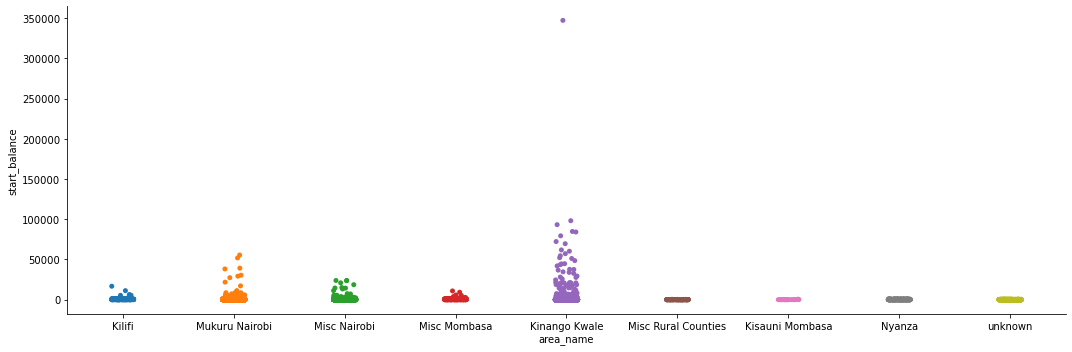

In [93]:
sns.catplot(data=sarafu_users, x="area_name", y="start_balance", aspect=3)

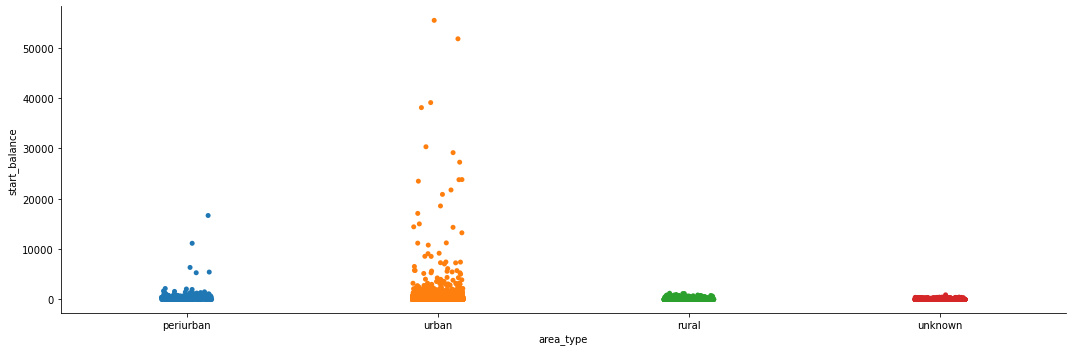

In [94]:
sns.catplot(data=sarafu_users[sarafu_users["area_name"] != "Kinango Kwale"], 
            x="area_type", y="start_balance", aspect=3)

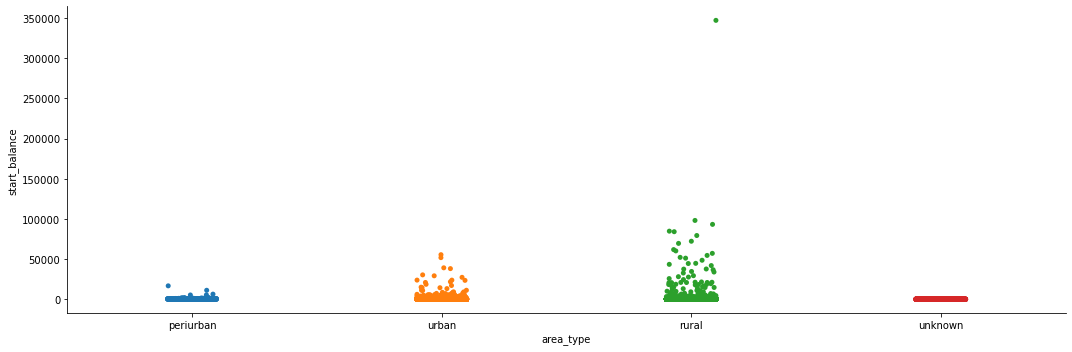

In [95]:
sns.catplot(data=sarafu_users, x="area_type", y="start_balance", aspect=3)

## Some Feature Engineering

Add some user data to the features that we'll use.

In [96]:
trainset = pd.merge(sarafu_trainset, sarafu_users, how='inner', on="id")
trainset

,id,inactive,account_type,registration_time,gender,area_name,area_type,business_type,start_balance
0,33064,1,individual,2020-08-10 13:28:13.820557,unknown,Kinango Kwale,rural,food,0.00
1,34782,0,individual,2020-08-19 11:13:07.797863,male,Mukuru Nairobi,urban,shop,0.00
2,30712,1,individual,2020-07-28 07:37:13.403603,male,Kinango Kwale,rural,farming,0.00
3,35689,0,individual,2020-08-24 12:27:00.324002,unknown,Kinango Kwale,rural,food,0.00
4,40015,0,individual,2020-10-09 09:29:44.204909,male,Kinango Kwale,rural,farming,0.00
...,...,...,...,...,...,...,...,...,...
5146,32376,1,individual,2020-08-06 07:39:53.539983,unknown,Misc Nairobi,urban,food,0.00
5147,36465,0,individual,2020-08-29 15:52:00.924168,unknown,Mukuru Nairobi,urban,labour,0.00
5148,36545,0,individual,2020-08-31 09:10:10.087413,unknown,Kinango Kwale,rural,food,0.00
5149,36932,0,individual,2020-09-04 13:40:20.915654,unknown,Kinango Kwale,rural,fuel/energy,0.00


In [97]:
testset = pd.merge(sarafu_testset, sarafu_users, how='inner', on="id")
testset

,id,account_type,registration_time,gender,area_name,area_type,business_type,start_balance
0,18774,individual,2020-05-05 06:45:53.090852,unknown,Kinango Kwale,rural,other,0.00
1,15108,individual,2020-04-20 09:13:26.342679,female,Mukuru Nairobi,urban,labour,100.98
2,22211,individual,2020-05-25 11:05:31.112923,male,Mukuru Nairobi,urban,labour,0.00
3,30692,individual,2020-07-28 06:49:52.117954,male,Kinango Kwale,rural,fuel/energy,0.00
4,37399,individual,2020-09-09 12:29:29.915180,male,Mukuru Nairobi,urban,food,0.00
...,...,...,...,...,...,...,...,...
1712,27925,individual,2020-07-08 04:06:48.178385,female,Mukuru Nairobi,urban,shop,0.00
1713,20245,individual,2020-05-12 13:16:21.638127,male,Nyanza,rural,transport,0.00
1714,36065,individual,2020-08-26 09:40:58.828007,female,Mukuru Nairobi,urban,food,0.00
1715,36739,individual,2020-09-02 09:57:03.571248,unknown,Mukuru Nairobi,urban,labour,0.00


## Turn timestamps into weeks.

Trainset:

In [98]:
trainset_registration_week = [
    pd.Timestamp(trainset["registration_time"][i]).week for i in 
    range(len(trainset))
    ]

trainset.registration_time = trainset_registration_week
trainset

,id,inactive,account_type,registration_time,gender,area_name,area_type,business_type,start_balance
0,33064,1,individual,33,unknown,Kinango Kwale,rural,food,0.00
1,34782,0,individual,34,male,Mukuru Nairobi,urban,shop,0.00
2,30712,1,individual,31,male,Kinango Kwale,rural,farming,0.00
3,35689,0,individual,35,unknown,Kinango Kwale,rural,food,0.00
4,40015,0,individual,41,male,Kinango Kwale,rural,farming,0.00
...,...,...,...,...,...,...,...,...,...
5146,32376,1,individual,32,unknown,Misc Nairobi,urban,food,0.00
5147,36465,0,individual,35,unknown,Mukuru Nairobi,urban,labour,0.00
5148,36545,0,individual,36,unknown,Kinango Kwale,rural,food,0.00
5149,36932,0,individual,36,unknown,Kinango Kwale,rural,fuel/energy,0.00


Testset:

In [99]:
testset_registration_week = [
    pd.Timestamp(testset["registration_time"][i]).week for i in 
    range(len(testset))
    ]

testset.registration_time = testset_registration_week
testset

,id,account_type,registration_time,gender,area_name,area_type,business_type,start_balance
0,18774,individual,19,unknown,Kinango Kwale,rural,other,0.00
1,15108,individual,17,female,Mukuru Nairobi,urban,labour,100.98
2,22211,individual,22,male,Mukuru Nairobi,urban,labour,0.00
3,30692,individual,31,male,Kinango Kwale,rural,fuel/energy,0.00
4,37399,individual,37,male,Mukuru Nairobi,urban,food,0.00
...,...,...,...,...,...,...,...,...
1712,27925,individual,28,female,Mukuru Nairobi,urban,shop,0.00
1713,20245,individual,20,male,Nyanza,rural,transport,0.00
1714,36065,individual,35,female,Mukuru Nairobi,urban,food,0.00
1715,36739,individual,36,unknown,Mukuru Nairobi,urban,labour,0.00


Transactions:

In [158]:
transactions_week = [
    pd.Timestamp(sarafu_transactions["time"][i]).week for i in 
    range(len(sarafu_transactions))
    ]

sarafu_transactions["time"] = transactions_week
sarafu_transactions

,time,id,target,amount
0,18,14799,2159,100.0
1,18,14799,2159,100.0
2,18,15928,15929,200.0
3,18,15975,16552,500.0
4,18,15975,16542,200.0
...,...,...,...,...
375481,44,-1,40841,50.0
375482,44,40841,39764,50.0
375483,44,225,324,150.0
375484,44,21390,5829,1200.0


## Remove account_type, id, and area type

In [110]:
trainset_dropped = trainset.drop(columns=["account_type", "id", "area_type"])

## Label Encoder

Encode gender.

In [111]:
label_encoder = LabelEncoder()
labels = [i for i in set(trainset_dropped["gender"])]
label_encoder.fit(labels)
trainset_dropped["gender"] = label_encoder.transform(trainset_dropped["gender"])
trainset_dropped

,inactive,registration_time,gender,area_name,business_type,start_balance
0,1,33,2,1,food,0.00
1,0,34,1,6,shop,0.00
2,1,31,1,1,farming,0.00
3,0,35,2,1,food,0.00
4,0,41,1,1,farming,0.00
...,...,...,...,...,...,...
5146,1,32,2,4,food,0.00
5147,0,35,2,6,labour,0.00
5148,0,36,2,1,food,0.00
5149,0,36,2,1,fuel/energy,0.00


Encode area name.

In [112]:
label_encoder = LabelEncoder()
labels = [i for i in set(trainset_dropped["area_name"])]
label_encoder.fit(labels)
trainset_dropped["area_name"] = label_encoder.transform(trainset_dropped["area_name"])
trainset_dropped

,inactive,registration_time,gender,area_name,business_type,start_balance
0,1,33,2,1,food,0.00
1,0,34,1,6,shop,0.00
2,1,31,1,1,farming,0.00
3,0,35,2,1,food,0.00
4,0,41,1,1,farming,0.00
...,...,...,...,...,...,...
5146,1,32,2,4,food,0.00
5147,0,35,2,6,labour,0.00
5148,0,36,2,1,food,0.00
5149,0,36,2,1,fuel/energy,0.00


Encode business type.

In [162]:
label_encoder = LabelEncoder()
labels = [i for i in set(trainset_dropped["business_type"])]
label_encoder.fit(labels)
trainset_dropped["business_type"] = label_encoder.transform(trainset_dropped["business_type"])
trainset_dropped

,inactive,registration_time,gender,area_name,business_type,start_balance
0,1,33,2,1,4,0.00
1,0,34,1,6,11,0.00
2,1,31,1,1,3,0.00
3,0,35,2,1,4,0.00
4,0,41,1,1,3,0.00
...,...,...,...,...,...,...
5146,1,32,2,4,4,0.00
5147,0,35,2,6,8,0.00
5148,0,36,2,1,4,0.00
5149,0,36,2,1,5,0.00


In [114]:
X = trainset_dropped.drop(columns="inactive")
Y = trainset_dropped["inactive"]

Now we can possibly add weekly transaction info, aggregate and/or average.

In [121]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
model_evaluation_cv(rf, X, Y)

Mean Accuracy: 0.6946224034168123 Standard Deviation 0.006385899515976896
Mean Precision: 0.6971461852067559 Standard Deviation 0.005958458261783265
Mean Recall: 0.6975344593282858 Standard Deviation 0.0023457670304008137
Mean F1 score: 0.6944282663560474 Standard Deviation 0.0021443139229639497
Mean Cohen's Kappa 0.40119000899776563 Standard Deviation 0.010129325713051043


In [123]:
knn = KNeighborsClassifier()

model_evaluation_cv(knn, X, Y)

Mean Accuracy: 0.6829741797709182 Standard Deviation 0.007523906959843135
Mean Precision: 0.6829741797709182 Standard Deviation 0.007523906959843135
Mean Recall: 0.6829741797709182 Standard Deviation 0.007523906959843135
Mean F1 score: 0.6829741797709182 Standard Deviation 0.007523906959843135
Mean Cohen's Kappa 0.3624214778543649 Standard Deviation 0.01708410004216555


In [137]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()

model_evaluation_cv(gb, X, Y)

Mean Accuracy: 0.7231605513492525 Standard Deviation 0.014582265158776114
Mean Precision: 0.7231605513492525 Standard Deviation 0.014582265158776114
Mean Recall: 0.7231605513492525 Standard Deviation 0.014582265158776114
Mean F1 score: 0.7231605513492525 Standard Deviation 0.014582265158776114
Mean Cohen's Kappa 0.44848046767788824 Standard Deviation 0.028318617601404698


Get transactions related to the users:

In [163]:
t = trainset.drop(columns=["account_type", "area_type"])
user_transactions = pd.merge(t, sarafu_transactions, how="inner", on="id")
user_transactions

,id,inactive,registration_time,gender,area_name,business_type,start_balance,time,target,amount
0,33064,1,33,2,1,food,0.00,33,6521,20.0
1,33064,1,33,2,1,food,0.00,33,3866,400.0
2,33064,1,33,2,1,food,0.00,33,3866,20.0
3,33064,1,33,2,1,food,0.00,34,3866,121.0
4,34782,0,34,1,6,shop,0.00,34,7332,20.0
...,...,...,...,...,...,...,...,...,...,...
133427,10848,0,10,0,1,farming,1223.37,41,11001,10000.0
133428,10848,0,10,0,1,farming,1223.37,41,11001,15000.0
133429,10848,0,10,0,1,farming,1223.37,42,11001,20000.0
133430,10848,0,10,0,1,farming,1223.37,42,11001,200.0


In [165]:
label_encoder = LabelEncoder()
labels = [i for i in set(user_transactions["business_type"])]
label_encoder.fit(labels)
user_transactions["business_type"] = label_encoder.transform(user_transactions["business_type"])

X2 = user_transactions.drop(columns=["id","inactive"])
Y2 = user_transactions["inactive"]

In [166]:
gb = GradientBoostingClassifier()

model_evaluation_cv(gb, X2, Y2)

Mean Accuracy: 0.8850426069042293 Standard Deviation 0.008987126471798139
Mean Precision: 0.8850426069042293 Standard Deviation 0.008987126471798139
Mean Recall: 0.8850426069042293 Standard Deviation 0.008987126471798139
Mean F1 score: 0.8850426069042293 Standard Deviation 0.00898712647179817
Mean Cohen's Kappa 0.4344239931401568 Standard Deviation 0.05131981925264415
